In [1]:
# Import required modules
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset from a CSV file (replace 'your_dataset.csv' with your actual file name)
data = pd.read_csv('TrainingDataStand.csv')


In [3]:

# Separate input features and output feature
X = data.iloc[:, :-1].values  
y = data.iloc[:, -1].values  


In [13]:
X_seq = []  # [num_samples - 3, 16]
y_seq = []

for i in range(3, len(data)):
    window =X[i-3:i+1]  # 4 timesteps
    X_seq.append(window)
    y_seq.append(y[i])  # current time target

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

In [14]:
# Sanity check
print(X_seq.shape)

(618744, 4, 8)


In [20]:

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [21]:
print(X_train.shape)

(433120, 4, 8)


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Dropout

# Define input shape
sequence_input = Input(shape=(4, 8), name='temporal_input')

# Temporal CNN layers
x = Conv1D(filters=32, kernel_size=2, activation='relu', padding='valid')(sequence_input)
x = Conv1D(filters=16, kernel_size=2, activation='relu', padding='valid')(x)
x = Flatten()(x)

# Fully connected layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

# Output
output = Dense(1, activation='tanh', name='steering_output')(x)

# Create and compile model
model = Model(inputs=sequence_input, outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ temporal_input (InputLayer)     │ (None, 4, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 3, 32)          │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 2, 16)          │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ steering_output (Dense)         │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,809 (22.69 KB)

 Trainable params: 5,809 (22.69 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Specify callback for logging in-epoch loss
from tensorflow.keras.callbacks import Callback
class BatchLossLogger(Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

# Instantiate the callback
batch_loss_logger = BatchLossLogger()

In [24]:
# Start the timer
start_time = time.time()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=1024,
    verbose=1,
    callbacks=[batch_loss_logger]
)

# Stop the timer
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training Time: {elapsed_time:.2f} seconds")


Epoch 1/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0069 - mae: 0.0417 - val_loss: 0.0013 - val_mae: 0.0216
Epoch 2/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0011 - mae: 0.0192 - val_loss: 0.0017 - val_mae: 0.0244
Epoch 3/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.0559e-04 - mae: 0.0174 - val_loss: 0.0017 - val_mae: 0.0239
Epoch 4/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 7.6799e-04 - mae: 0.0160 - val_loss: 0.0018 - val_mae: 0.0249
Epoch 5/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.5058e-04 - mae: 0.0148 - val_loss: 0.0014 - val_mae: 0.0229
Epoch 6/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.3713e-04 - mae: 0.0138 - val_loss: 0.0013 - val_mae: 0.0221
Epoch 7/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.5044e-04 - mae: 0.0129 - val_loss: 0.0011 - val_mae: 0.0214
Epoch 8/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.9309e-04 - mae: 0.0123 - val_loss: 0.0011 - val_mae: 0.0214
Epoch 9/50
423/423 ━━━━━━━━━━━━━

2901/2901 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


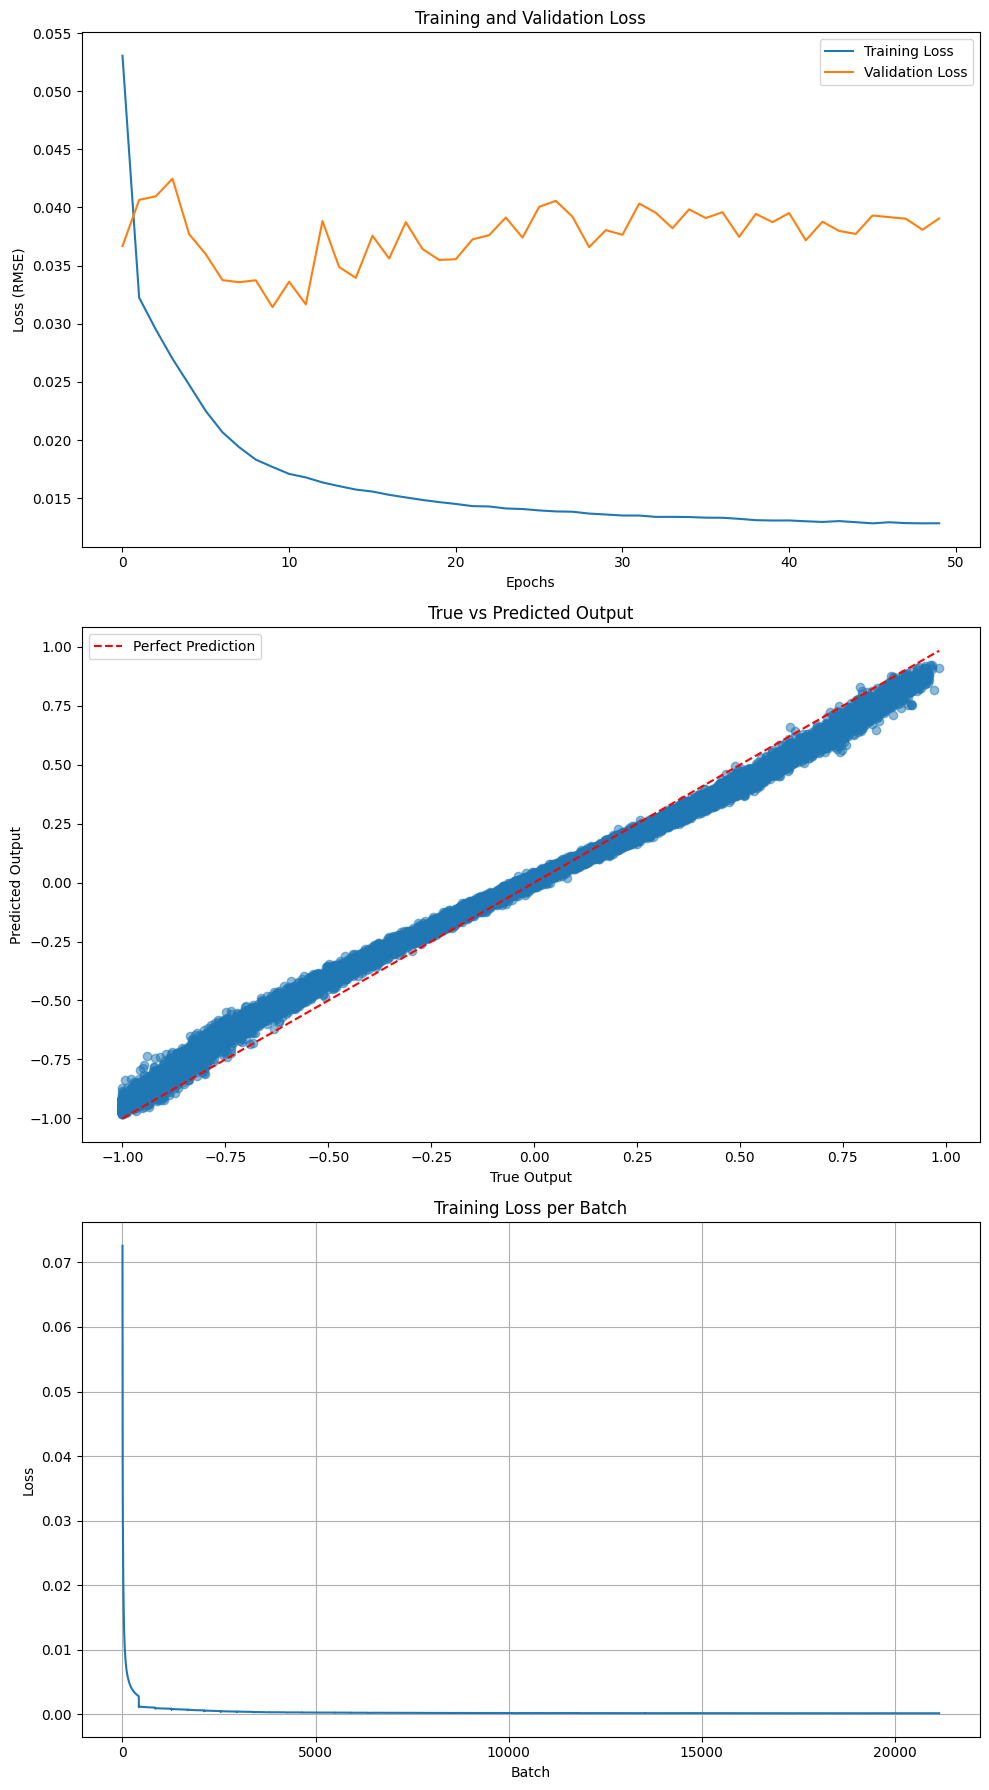

In [25]:
# Create one figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Plot 1: Training and Validation Loss
axs[0].plot(np.sqrt(history.history['loss']), label='Training Loss')
axs[0].plot(np.sqrt(history.history['val_loss']), label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss (RMSE)')
# axs[0].set_ylim([0.025, 0.035])
axs[0].legend()

# Plot 2: True vs Predicted Output
y_pred = model.predict(X_test)
axs[1].scatter(y_test, y_pred, alpha=0.5)
axs[1].set_title('True vs Predicted Output')
axs[1].set_xlabel('True Output')
axs[1].set_ylabel('Predicted Output')
axs[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
axs[1].legend()

# Plot 3: Batch Loss
axs[2].plot(batch_loss_logger.batch_losses)
axs[2].set_title('Training Loss per Batch')
axs[2].set_xlabel('Batch')
axs[2].set_ylabel('Loss')
axs[2].grid(True)
# axs[2].set_ylim([0.001, 0.002])

plt.tight_layout()
plt.show()

In [26]:
# Export the model
model.export("SteeringModel_Iteration1")

INFO:tensorflow:Assets written to: SteeringModel_Iteration1\assets


INFO:tensorflow:Assets written to: SteeringModel_Iteration1\assets


Saved artifact at 'SteeringModel_Iteration1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4, 8), dtype=tf.float32, name='temporal_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2462614534480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462614535632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462614534864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462614535824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462615027984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462615029520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462615028752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462615030672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462615030096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2462615031632: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [13]:
# Feature importance
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, scoring='neg_mean_absolute_error')
feature_importance = result.importances_mean
print("Feature Importance:", feature_importance)

2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 934us/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 959us/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 908us/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 879us/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 880us/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 935us/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 993us/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 956us/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 987us/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 954us/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step  
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 890us/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 865us/step
2901/2901 ━━━━━━━━━━━━━━━━━━━━ 3s 987us/step
2901/2901 ━━━━━━━━━━━━━━━━